# `two_pass_tracking.zarr` visualization

This notebook loads tracking outputs from `two_pass_tracking.zarr` (a Zarr v2 directory store) and generates a few quick sanity-check plots:

- Coverage (how many frames each track exists)
- Example track time series (x/y/area)
- XY trajectories
- Per-frame scatter of detections

It avoids `xarray.open_zarr()` here because this Zarr store is organized as plain groups/arrays rather than an xarray Dataset.

In [5]:
from __future__ import annotations

import json
import math
from functools import lru_cache
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numcodecs import Blosc

plt.rcParams['figure.dpi'] = 120


In [6]:
ZARR_PATH = Path('two_pass_tracking.zarr')
assert ZARR_PATH.exists(), f"Missing {ZARR_PATH} (run tracking first, or point ZARR_PATH at the correct folder)."

ROOT_ATTRS = json.loads((ZARR_PATH / '.zattrs').read_text())
ROOT_ATTRS

{'fps': 20.0, 'n_mouth_tracks': 1, 'n_bulb_tracks': 446, 'n_frames': 1000}

## Minimal Zarr v2 reader

This store uses Zarr v2 metadata files (`.zgroup`, `.zattrs`, `.zarray`) and Blosc-compressed chunk files. The helpers below read arrays directly from disk (no `zarr` dependency).

In [7]:
@lru_cache(maxsize=None)
def _read_zarray_meta(array_dir: str) -> dict:
    return json.loads((Path(array_dir) / '.zarray').read_text())


def read_zarr_v2_array(array_path: Path, *, allow_missing_chunks: bool = True) -> np.ndarray:
    """Load a Zarr v2 array from `array_path` into a NumPy array.

    Notes
    -----
    - Supports Blosc-compressed chunks (as written by this project).
    - For missing chunks, fills with `fill_value` from metadata when `allow_missing_chunks=True`.
    """
    meta = _read_zarray_meta(str(array_path))
    shape = tuple(meta['shape'])
    chunks = tuple(meta['chunks'])
    dtype = np.dtype(meta['dtype'])
    order = meta.get('order', 'C')
    fill_value = meta.get('fill_value', 0)

    comp = meta.get('compressor') or {}
    if comp.get('id') != 'blosc':
        raise ValueError(f"Unsupported compressor: {comp}")

    codec = Blosc(
        cname=comp.get('cname', 'lz4'),
        clevel=comp.get('clevel', 5),
        shuffle=comp.get('shuffle', 1),
        blocksize=comp.get('blocksize', 0) or 0,
    )

    out = np.full(shape, fill_value, dtype=dtype)

    n_chunks = [math.ceil(s / c) for s, c in zip(shape, chunks)]
    sep = meta.get('dimension_separator', '.')

    for chunk_index in product(*[range(n) for n in n_chunks]):
        chunk_name = sep.join(str(i) for i in chunk_index)
        chunk_file = array_path / chunk_name
        if not chunk_file.exists():
            if allow_missing_chunks:
                continue
            raise FileNotFoundError(chunk_file)

        decoded = codec.decode(chunk_file.read_bytes())
        if not isinstance(decoded, (bytes, bytearray, memoryview)):
            decoded = bytes(decoded)

        out_slices = []
        in_slices = []
        for i, c, s in zip(chunk_index, chunks, shape):
            start = i * c
            stop = min(start + c, s)
            out_slices.append(slice(start, stop))
            in_slices.append(slice(0, stop - start))

        chunk_arr = np.frombuffer(decoded, dtype=dtype).reshape(chunks, order=order)
        out[tuple(out_slices)] = chunk_arr[tuple(in_slices)]

    return out


def load_group_arrays(group: str, names: list[str]) -> dict[str, np.ndarray]:
    base = ZARR_PATH / group
    return {name: read_zarr_v2_array(base / name) for name in names}


## Load arrays

In [8]:
fps = float(ROOT_ATTRS.get('fps', np.nan))
frame_coord = read_zarr_v2_array(ZARR_PATH / 'frame_coord')  # 0..n_frames-1

# Track IDs (0..n_tracks-1)
bulb_track_id = read_zarr_v2_array(ZARR_PATH / 'bulb' / 'track')
mouth_track_id = read_zarr_v2_array(ZARR_PATH / 'mouth' / 'track')

print('fps:', fps)
print('n_frames:', frame_coord.size)
print('bulb tracks:', bulb_track_id.size)
print('mouth tracks:', mouth_track_id.size)


fps: 20.0
n_frames: 1000
bulb tracks: 446
mouth tracks: 1


In [9]:
bulb = load_group_arrays('bulb', ['x', 'y', 'area', 'major_axis_length_mm', 'frame'])
mouth = load_group_arrays('mouth', ['x', 'y', 'area', 'major_axis_length_mm', 'frame'])

bulb_x, bulb_y = bulb['x'], bulb['y']
mouth_x, mouth_y = mouth['x'], mouth['y']

bulb_presence = np.isfinite(bulb_x) & np.isfinite(bulb_y)
mouth_presence = np.isfinite(mouth_x) & np.isfinite(mouth_y)

bulb_track_len = bulb_presence.sum(axis=1)
mouth_track_len = mouth_presence.sum(axis=1)

print('bulb detections:', int(bulb_presence.sum()))
print('mouth detections:', int(mouth_presence.sum()))
print('bulb max track length:', int(bulb_track_len.max()))
print('mouth max track length:', int(mouth_track_len.max()))


bulb detections: 10098
mouth detections: 970
bulb max track length: 190
mouth max track length: 970


## Coverage / track length

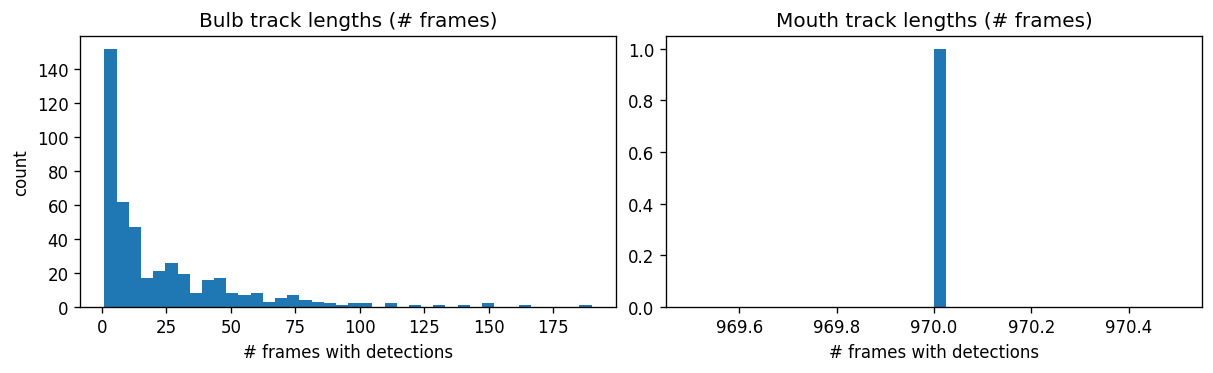

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax[0].hist(bulb_track_len, bins=40)
ax[0].set_title('Bulb track lengths (# frames)')
ax[0].set_xlabel('# frames with detections')
ax[0].set_ylabel('count')

ax[1].hist(mouth_track_len, bins=40)
ax[1].set_title('Mouth track lengths (# frames)')
ax[1].set_xlabel('# frames with detections')

plt.show()


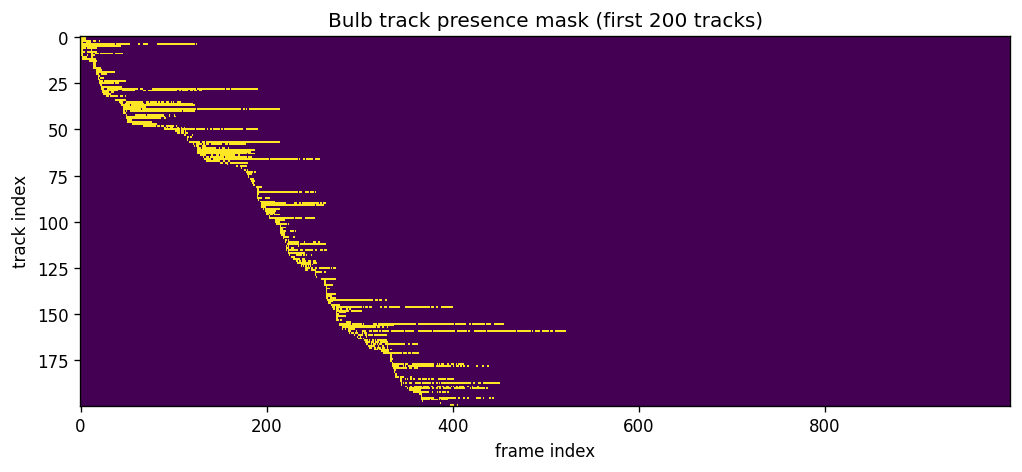

In [11]:
# Heatmap of presence for the first N bulb tracks
N = min(200, bulb_presence.shape[0])

plt.figure(figsize=(10, 4))
plt.imshow(bulb_presence[:N].astype(np.uint8), aspect='auto', interpolation='nearest')
plt.title(f'Bulb track presence mask (first {N} tracks)')
plt.xlabel('frame index')
plt.ylabel('track index')
plt.show()


## Inspect a single track

In [12]:
# Pick a track to inspect
track_idx = int(np.argmax(bulb_track_len))
track_idx

159

In [13]:
mask = bulb_presence[track_idx]
frames = frame_coord[mask]
seconds = frames / fps if np.isfinite(fps) else frames

df = pd.DataFrame({
    'frame': frames,
    't': seconds,
    'x': bulb_x[track_idx, mask],
    'y': bulb_y[track_idx, mask],
    'area': bulb['area'][track_idx, mask],
    'major_axis_length_mm': bulb['major_axis_length_mm'][track_idx, mask],
})

df.head()


,frame,t,x,y,area,major_axis_length_mm
0,288,14.40,859.500000,616.800000,10.0,0.040988
1,289,14.45,867.500000,630.500000,8.0,0.044721
2,290,14.50,872.333333,635.500000,6.0,0.038297
3,297,14.85,862.666667,659.500000,6.0,0.038297
4,303,15.15,878.333333,656.666667,6.0,0.036515


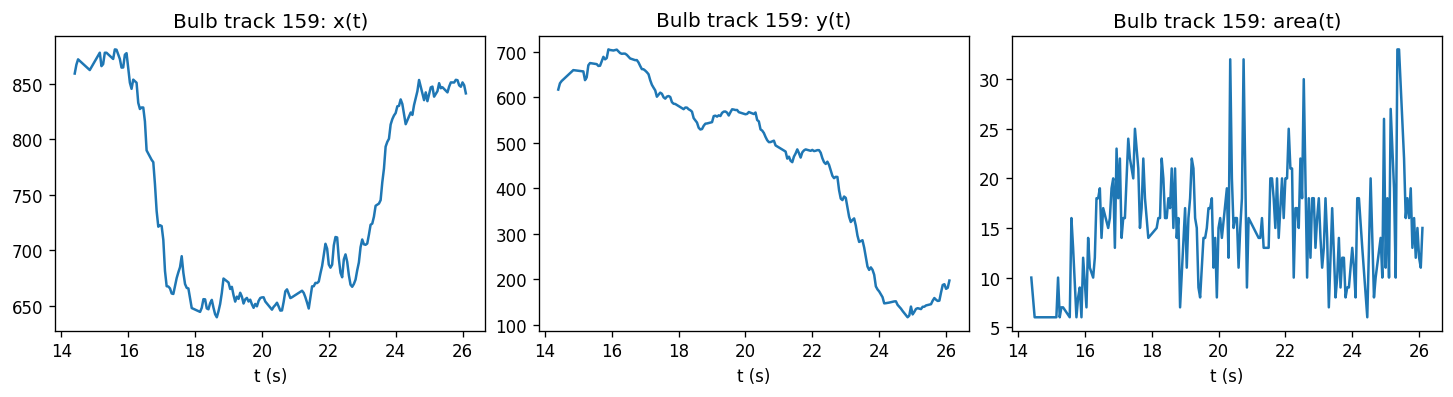

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.2), constrained_layout=True)

ax[0].plot(df['t'], df['x'])
ax[0].set_title(f'Bulb track {track_idx}: x(t)')
ax[0].set_xlabel('t (s)' if np.isfinite(fps) else 'frame')

ax[1].plot(df['t'], df['y'])
ax[1].set_title(f'Bulb track {track_idx}: y(t)')
ax[1].set_xlabel('t (s)' if np.isfinite(fps) else 'frame')

ax[2].plot(df['t'], df['area'])
ax[2].set_title(f'Bulb track {track_idx}: area(t)')
ax[2].set_xlabel('t (s)' if np.isfinite(fps) else 'frame')

plt.show()


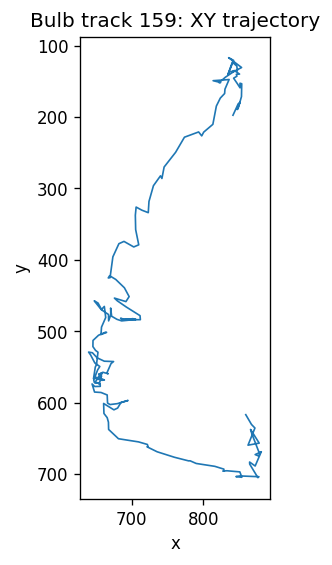

In [15]:
# XY trajectory (image-style coordinates: invert Y axis)
plt.figure(figsize=(5, 5))
plt.plot(df['x'], df['y'], linewidth=1)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Bulb track {track_idx}: XY trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Per-frame scatter (all detections)

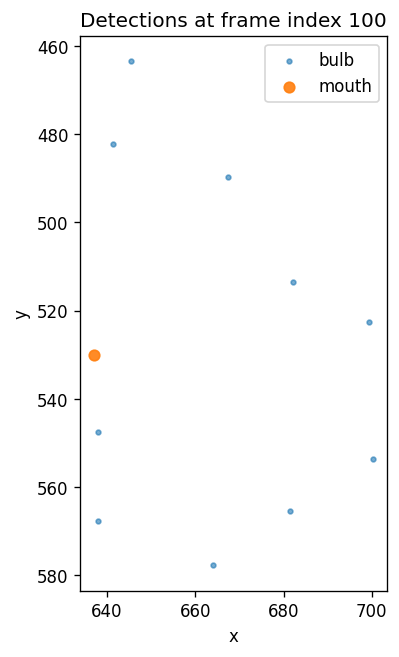

In [16]:
frame_idx = 100  # 0-based index into the arrays

bx = bulb_x[:, frame_idx]
by = bulb_y[:, frame_idx]

mx = mouth_x[:, frame_idx]
my = mouth_y[:, frame_idx]

bulb_mask = np.isfinite(bx) & np.isfinite(by)
mouth_mask = np.isfinite(mx) & np.isfinite(my)

plt.figure(figsize=(6, 6))
plt.scatter(bx[bulb_mask], by[bulb_mask], s=8, alpha=0.6, label='bulb')
plt.scatter(mx[mouth_mask], my[mouth_mask], s=40, alpha=0.9, label='mouth')
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Detections at frame index {frame_idx}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Notes

- `bulb/frame` and `mouth/frame` contain NaNs when a track is missing. They appear to be 1-based frame numbers; this notebook uses `frame_coord` (0-based) for indexing/time.
- If you want to overlay these tracks on video frames, we can extend this notebook to load the corresponding frames (e.g. from `saved_videos/`) and draw the bounding boxes.